In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label, remove_small_objects
from skimage.measure import regionprops
from skimage.io import imread
from skimage.color import label2rgb

In [2]:
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

(2647, 2865)
(2647, 2865)


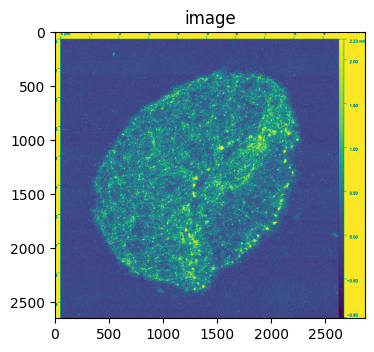

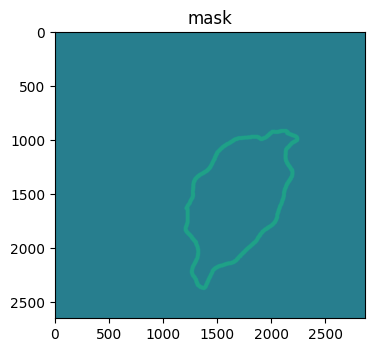

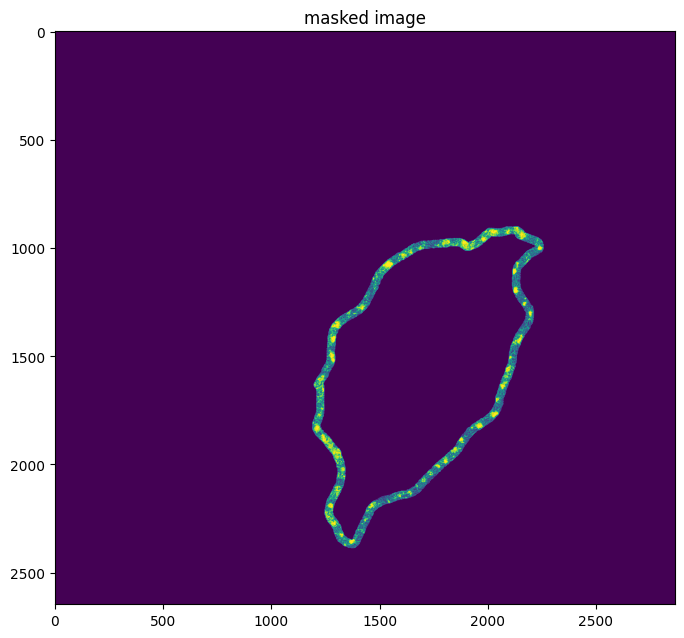

In [3]:
# Load pre-flattened image
image_path = Path('./fibril_experiment/img4_20230118_KPN001_25mMMgCl2_Vac(2).0_00020.png')
mask_path = Path('./fibril_experiment/msk4_task-51-annotation-29-by-1-tag-fibril-0.png')

image = imread(image_path, as_gray=True)
print(image.shape)
mask = imread(mask_path)
mask = mask.astype(bool)
print(mask.shape)

plot(image, title='image', figsize=(4, 4), zlimit=False)
plot(mask, title='mask', figsize=(4, 4))

masked = np.ma.masked_array(data=image, mask=np.invert(mask), fill_value=0).filled()
plot(masked, title='masked image', zlimit=False)

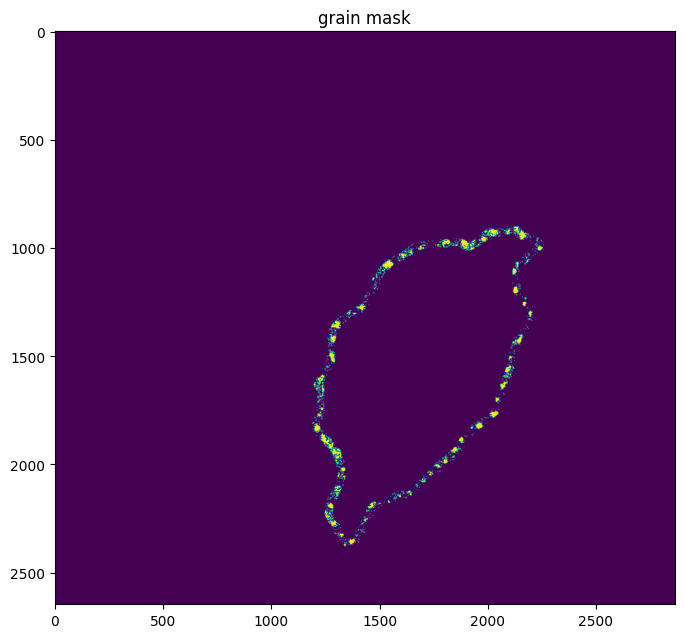

[False  True]


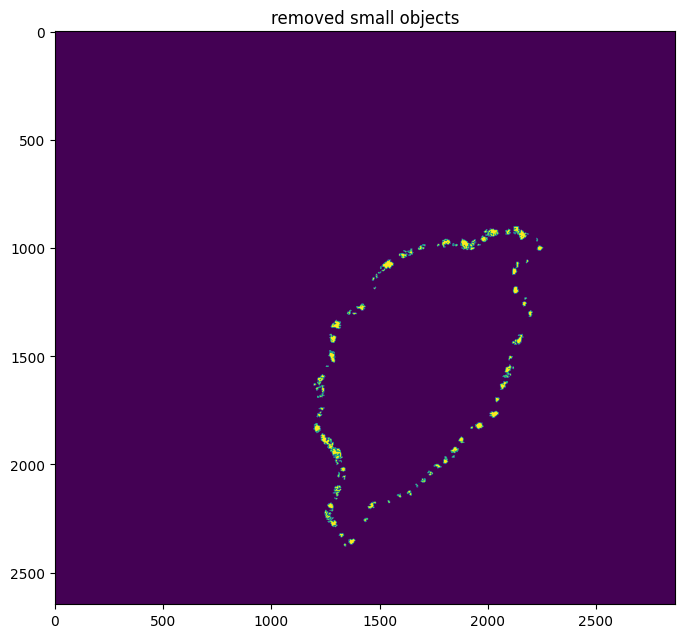

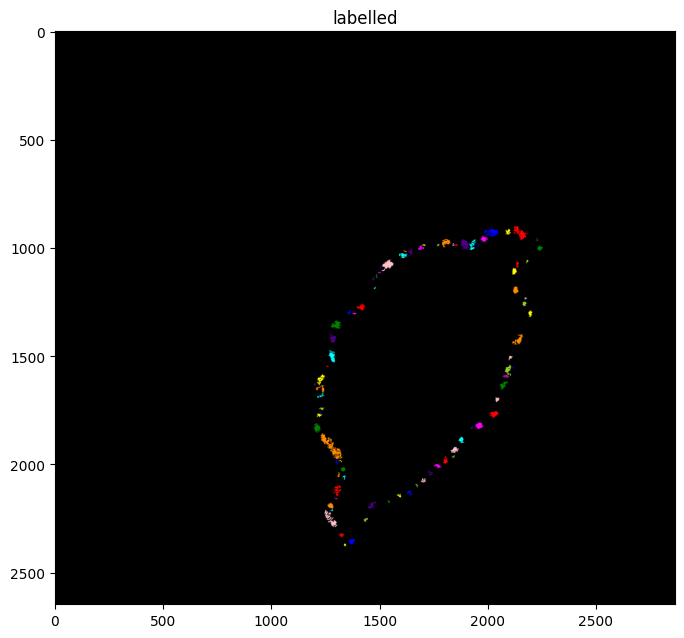

In [4]:
std_dev_multiplier = 2.5
threshold = np.mean(masked[masked != 0.0]) + np.std(masked) * std_dev_multiplier
grain_mask = masked > threshold
plot(grain_mask, title='grain mask', zlimit=False)
print(np.unique(grain_mask))
removed_small_objects = remove_small_objects(grain_mask, 50)
plot(removed_small_objects, title='removed small objects', zlimit=False)
labelled = label(removed_small_objects)
coloured_labels = label2rgb(labelled, bg_label=0)
plot(coloured_labels, title='labelled')

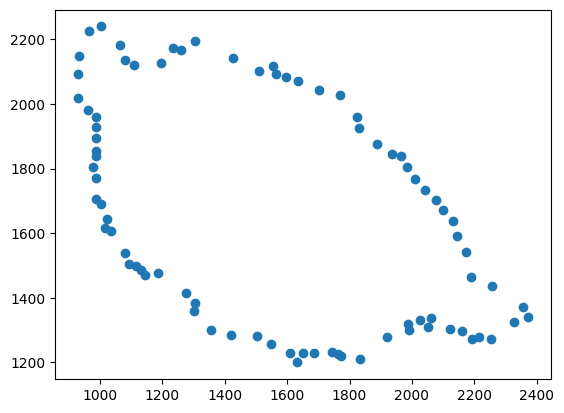

In [5]:
def get_points(binary_img) -> tuple:
    labelled = label(binary_img)
    regions = regionprops(labelled)
    points = np.ndarray((len(regions), 2))
    for props_index, props in enumerate(regions):
        points[props_index, :] = props.centroid

    return points

points = get_points(labelled)

plt.scatter(points[:, 0], points[:, 1])

In [6]:
def is_clockwise(p_1: tuple, p_2: tuple, p_3: tuple) -> bool:
    """Function to determine if three points make a clockwise or counter-clockwise turn.

    Parameters
    ----------
    p_1: tuple
        First point to be used to calculate turn.
    p_2: tuple
        Second point to be used to calculate turn.
    p_3: tuple
        Third point to be used to calculate turn.

    Returns
    -------
    boolean
        Indicator of whether turn is clockwise.
    """

    rotation_matrix = np.array(((p_1[0], p_1[1], 1), (p_2[0], p_2[1], 1), (p_3[0], p_3[1], 1)))
    return not np.linalg.det(rotation_matrix) > 0

def get_triangle_height(base_point_1: np.array, base_point_2: np.array, top_point: np.array) -> float:
    """Returns the height of a triangle defined by the input point vectors.
    Parameters
    ----------
    base_point_1: np.ndarray
        a base point of the triangle, eg: [5, 3].

    base_point_2: np.ndarray
        a base point of the triangle, eg: [8, 3].

    top_point: np.ndarray
        the top point of the triangle, defining the height from the line between the two base points, eg: [6,10].

    Returns
    -------
    Float
        The height of the triangle - ie the shortest distance between the top point and the line between the two base points.
    """

    # Height of triangle = A/b = ||AB X AC|| / ||AB||
    a_b = base_point_1 - base_point_2
    a_c = base_point_1 - top_point
    return np.linalg.norm(np.cross(a_b, a_c)) / np.linalg.norm(a_b)

def ferets(edges: np.ndarray) -> float:
    """Returns the minimum and maximum feret diameters for a grain.
    These are defined as the smallest and greatest distances between
    a pair of callipers that are rotating around a 2d object, maintaining
    contact at all times.

    Parameters
    ----------
    edge_points: list
        a list of the vector positions of the pixels comprising the edge of the
        grain. Eg: [[0, 0], [1, 0], [2, 1]]
    Returns
    -------
    min_feret: float
        the minimum feret diameter of the grain
    max_feret: float
        the maximum feret diameter of the grain"""

    # Sort the vectors by x coordinate then y coordinate
    sorted_indices = np.lexsort((edges[:, 1], edges[:, 0]))
    sorted = edges[sorted_indices]

    # Construct upper and lower hulls for the edge points.
    upper_hull = []
    lower_hull = []
    for point in sorted:
        while len(lower_hull) > 1 and is_clockwise(lower_hull[-2], lower_hull[-1], point):
            lower_hull.pop()
        lower_hull.append(point)
        while len(upper_hull) > 1 and not is_clockwise(upper_hull[-2], upper_hull[-1], point):
            upper_hull.pop()
        upper_hull.append(point)
    
    upper_hull = np.array(upper_hull)
    lower_hull = np.array(lower_hull)

    # Create list of contact vertices for calipers on the antipodal hulls
    contact_points = []
    upper_index = 0
    lower_index = len(lower_hull) - 1
    min_feret = None
    while upper_index < len(upper_hull) - 1 or lower_index > 0:
        contact_points.append([lower_hull[lower_index, :], upper_hull[upper_index, :]])
        # If we have reached the end of the upper hull, continute iterating over the lower hull
        if upper_index == len(upper_hull) - 1:
            lower_index -= 1
            small_feret = get_triangle_height(
                np.array(lower_hull[lower_index + 1, :]),
                np.array(lower_hull[lower_index, :]),
                np.array(upper_hull[upper_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        # If we have reached the end of the lower hull, continue iterating over the upper hull
        elif lower_index == 0:
            upper_index += 1
            small_feret = get_triangle_height(
                np.array(upper_hull[upper_index - 1, :]),
                np.array(upper_hull[upper_index, :]),
                np.array(lower_hull[lower_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        # Check if the gradient of the last point and the proposed next point in the upper hull is greater than the gradient
        # of the two corresponding points in the lower hull, if so, this means that the next point in the upper hull
        # will be encountered before the next point in the lower hull and vice versa.
        # Note that the calculation here for gradients is the simple delta upper_y / delta upper_x > delta lower_y / delta lower_x
        # however I have multiplied through the denominators such that there are no instances of division by zero. The
        # inequality still holds and provides what is needed.
        elif (upper_hull[upper_index + 1, 1] - upper_hull[upper_index, 1]) * (
            lower_hull[lower_index, 0] - lower_hull[lower_index - 1, 0]
        ) > (lower_hull[lower_index, 1] - lower_hull[lower_index - 1, 1]) * (
            upper_hull[upper_index + 1, 0] - upper_hull[upper_index, 0]
        ):
            # If the upper hull is encoutnered first, increment the iteration index for the upper hull
            # Also consider the triangle that is made as the two upper hull vertices are colinear with the caliper
            upper_index += 1
            small_feret = get_triangle_height(
                np.array(upper_hull[upper_index - 1, :]),
                np.array(upper_hull[upper_index, :]),
                np.array(lower_hull[lower_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        else:
            # The next point in the lower hull will be encountered first, so increment the lower hull iteration index.
            lower_index -= 1
            small_feret = get_triangle_height(
                np.array(lower_hull[lower_index + 1, :]),
                np.array(lower_hull[lower_index, :]),
                np.array(upper_hull[upper_index, :]),
            )

            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret

    contact_points = np.array(contact_points)

    # Find the minimum and maximum distance in the contact points
    max_feret = None
    for point_pair in contact_points:
        dist = np.sqrt((point_pair[0, 0] - point_pair[1, 0]) ** 2 + (point_pair[0, 1] - point_pair[1, 1]) ** 2)
        if max_feret is None or max_feret < dist:
            max_feret = dist

    return min_feret, max_feret

In [7]:
def shoelace(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    area = 0
    for index in range(len(points)-1):
        matrix = points[index:index+2, :].T
        area += np.linalg.det(matrix)
    return np.round(area/2, 5)

def polygon_perimeter(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    perimeter = 0
    for i in range(len(points)-1):
        point1 = points[i, :]
        point2 = points[i+1, :]
        perimeter += np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return perimeter

In [8]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    max_heights = np.zeros(len(region_props))
    mean_heights = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume
        max_heights[props_index] = np.max(region_values)
        mean_heights[props_index] = np.mean(region_values)

    return {
        'areas': areas,
        'volumes': volumes,
        'max_heights': max_heights,
        'mean_heights': mean_heights,
        'number_of_regions': len(region_props),
    }

In [9]:
area = shoelace(points)
print(f'area: {area:.2f}')
perimeter = polygon_perimeter(points)
print(f'perimeter: {perimeter:.2f}')
min_feret, max_feret = ferets(points)
print(f'min_feret: {min_feret:.2f} | max_feret: {max_feret:.2f}')
regionstats = region_stats(labelled_image=labelled, image=image)
print('- node stats -')
print(f'node areas | min: {np.min(regionstats["areas"]):.2f} max: {np.max(regionstats["areas"]):.2f} mean: {np.mean(regionstats["areas"]):.2f}')
print(f'node voluems | min: {np.min(regionstats["volumes"]):.2f} max: {np.max(regionstats["volumes"]):.2f} mean: {np.mean(regionstats["volumes"]):.2f}')
print(f'mean node height values | min: {np.min(regionstats["mean_heights"]):.2f} max: {np.max(regionstats["mean_heights"]):.2f} mean: {np.mean(regionstats["mean_heights"]):.2f}')
print(f'max node height values | min: {np.min(regionstats["max_heights"]):.2f} max: {np.max(regionstats["max_heights"]):.2f} mean: {np.mean(regionstats["max_heights"]):.2f}')



area: 169880.42
perimeter: 30456.48
min_feret: 828.29 | max_feret: 1665.87
- node stats -
node areas | min: 50.00 max: 3191.00 mean: 407.28
node voluems | min: 41.41 max: 2877.43 mean: 370.84
mean node height values | min: 0.82 max: 0.96 mean: 0.89
max node height values | min: 0.87 max: 1.00 mean: 0.99
